In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from mingpt.model import GPT
from mingpt.utils import set_seed
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import numpy as np
from scipy.stats import norm
set_seed(3407)

In [2]:
# Load in UL2 tokenizer to see what's going on
from transformers import AutoTokenizer, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

new_tokens = [f'<new_id_{i}>' for i in range(200)]
tokenizer.add_tokens(new_tokens)
tokenizer.add_tokens(['[S2S]', '[NLU]', '[NLG]'])

tokenizer

PreTrainedTokenizer(name_or_path='gpt2', vocab_size=50257, model_max_len=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True)})

In [3]:
dataset = load_dataset("togethercomputer/RedPajama-Data-1T-Sample", 'plain_text', cache_dir='datasets')
dataset = dataset['train']

# Custom dataset class for the Red Pajama dataset
class RedPajamaDataset(Dataset):
    def __init__(self, data, max_length=1024, ul2_switch=False):
        self.data = data
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.tokenizer.add_tokens([f'new_id_{i}' for i in range(200)])
        self.tokenizer.add_tokens(['[S2S]', '[NLU]', '[NLG]'])
        self.tokenizer.pad_token_id = 50256
        self.max_length = max_length
        self.vocab_size = self.tokenizer.vocab_size
        self.token_dict = {'s': ['[S2S]', self._s_denoising], 'r': ['[NLU]', self._r_denoising], 'x': ['[NLG]', self._x_denoising]}
        self.ul2_switch = ul2_switch

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']

        if self.ul2_switch:
            # Get the token to prepend and function to use.
            begin_id, func = token_dict[np.random.choice(['s', 'r', 'x'], size=1, p=[0.5, 0.25, 0.25])[0]]

            # Prepend token to string and tokenize
            text = begin_id + ' ' + text
            ids = self.tokenizer.encode(text, truncation=True, max_length=self.max_length, return_tensors='pt', add_special_tokens=True, padding=True)

            # Return the tokens
            return func(ids, self.tokenizer)
        
        elif not self.ul2_switch:
            # Tokenize the text
            tokens = self.tokenizer.encode(text, add_special_tokens=True, max_length=self.max_length, truncation=True, return_tensors='pt', padding=True)
            
            # Split the tokens into chunks of max_length
            # Shift the tokens to get targets (excluding the [CLS] token)
            target_tokens = tokens[:, 1:].clone()  # Exclude the [CLS] token
            tokens = tokens[:, :-1]  # Exclude the last token to match the shifted targets
            return tokens, target_tokens

    # Helper functions! These will implement the UL2 tokenization.
    def _r_denoising(ids, tokenizer, corruption_pct=0.15, span_length=np.arange(2,6)):
        chance = (corruption_pct / np.mean(span_length)) * (1 + np.max(span_length) / len(ids))
        old_toks = []

        steps_to_skip = 0
        tokens_used = 0

        for i in range(1, len(ids)):
            if steps_to_skip > 0:
                steps_to_skip -= 1
                continue

            if np.random.random() < chance:
                # Get the token we are using for this space
                mask_token = tokenizer.convert_tokens_to_ids(new_tokens[tokens_used])
                tokens_used += 1

                span = np.random.choice(span_length)
                old_toks.append(mask_token)
                old_toks.extend(ids[i:i+span].copy())
                ids = ids[:i] + [mask_token] + ids[i+span:]

                steps_to_skip = span
            
        
        return ids + [tokenizer.eos_token_id] * (self.max_length - len(ids)), old_toks + [tokenizer.eos_token_id] * (self.max_length - len(old_toks))


    def _s_denoising(ids, tokenizer):
        # Get the length of our input
        len_ids = len(ids)

        # Build Gaussian distribution of probabilities for each token
        p = norm.pdf(np.arange(len_ids)/len_ids, loc=np.mean(np.arange(len_ids)/len_ids), scale=np.std(np.arange(len_ids)/len_ids))

        # Normalize the probabilities and get the index: to remove.
        remove_index = np.random.choice(np.arange(len_ids), p=p/p.sum())

        # Get the token we are using for this space
        mask_token = tokenizer.convert_tokens_to_ids(new_tokens[0])

        # Get the tokens we are removing
        old_tok = [mask_token]
        old_tok.extend(ids[remove_index:].copy())

        # Mask the tokens
        ids = ids[:remove_index]
        ids[-1] = mask_token
        return ids + [tokenizer.eos_token_id] * (self.max_length - len(ids)), old_tok + [tokenizer.eos_token_id] * (self.max_length - len(old_tok))   

        
    def _x_denoising(ids, tokenizer, corruption_pct=0.50, span_length=np.arange(2,6)):
        return self._r_denoising(ids, tokenizer, corruption_pct, span_length)
    

# Create an instance of the custom dataset
red_pajama_dataset = RedPajamaDataset(dataset)

Found cached dataset red_pajama-data-1_t-sample (/Users/dylanskinner/Desktop/CS 674 Projects/MinGPT_UL2/datasets/togethercomputer___red_pajama-data-1_t-sample/plain_text/1.0.0/6ea3bc8ec2e84ec6d2df1930942e9028ace8c5b9d9143823cf911c50bbd92039)


  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
config = GPT.get_default_config()
config.vocab_size = red_pajama_dataset.vocab_size
config.block_size = red_pajama_dataset.max_length
a = (torch.ones(config.block_size, config.block_size).view(1, 1, config.block_size, config.block_size))
print(a)
print(a.shape)

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])
torch.Size([1, 1, 1024, 1024])


In [8]:
# create a GPT instance
from mingpt.model import GPT
import os

checkpoint_dir = 'red_pajama'
dir_path = f'./checkpoints/{checkpoint_dir}'

if not os.path.exists(dir_path):
    # If the directory doesn't exist, create it
    os.makedirs(dir_path)
    checkpoints = os.listdir(dir_path)
else:
    checkpoints = os.listdir(dir_path)

checkpoints.sort()



model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = red_pajama_dataset.vocab_size
model_config.block_size = red_pajama_dataset.max_length
# model_config.checkpoint = f'checkpoints/{checkpoint_dir}/' + checkpoints[-1] if checkpoints else None
model_config.checkpoint = None
model_config.use_ul2 = True
model = GPT(model_config)

number of parameters: 2.55M


In [9]:
# create a Trainer object
from mingpt.trainer import Trainer
iters = 500

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = iters + model.iter_num if model_config.checkpoint else iters  # This is a change
train_config.num_workers = 0
train_config.checkpoint_iters = 100     # This is a change
train_config.batch_size = 1
train_config.checkpoint_name = f'{checkpoint_dir}/checkpoint_ul2'  # This is a change.
trainer = Trainer(train_config, model, red_pajama_dataset)

running on device cpu


iter_dt 0.00ms; iter 0: train loss 10.84486
iter_dt 381.73ms; iter 100: train loss 8.40953
iter_dt 516.30ms; iter 200: train loss 8.48434
iter_dt 408.43ms; iter 300: train loss 8.06138
iter_dt 160.75ms; iter 400: train loss 8.09212


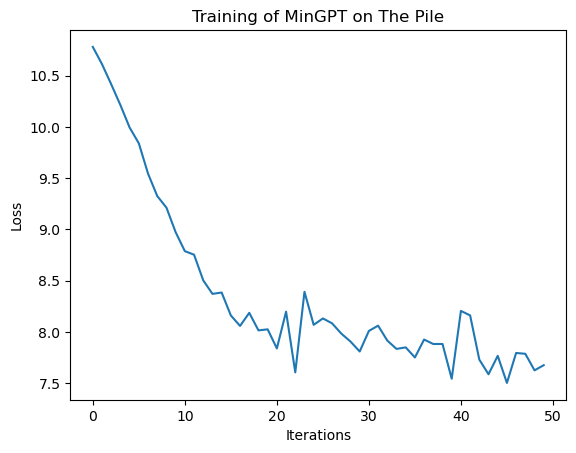

In [10]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

# Plot the loss
losses = trainer.curr_loss
x = 10
new_losses = np.mean(np.array(losses).reshape(-1, x), axis=1)

plt.plot(np.arange(len(new_losses)), new_losses)
plt.title('Training of MinGPT on The Pile')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [21]:
# See if generate works.
test_string = tokenizer.encode('new_id_15', truncation=True, max_length=1024, return_tensors='pt', add_special_tokens=True)
model.generate(test_string, 100, top_k=10, temperature=1.0)

IndexError: index out of range in self

In [128]:
new_tokens = [f'<new_id_{i}>' for i in range(200)]
tokenizer.add_tokens(new_tokens)
tokenizer.add_tokens(['[S2S]', '[NLU]', '[NLG]'])

def r_denoising(ids, tokenizer, corruption_pct=0.15, span_length=np.arange(2,6)):
    chance = (corruption_pct / np.mean(span_length)) * (1 + np.max(span_length) / len(ids))
    old_toks = []

    steps_to_skip = 0
    tokens_used = 0

    for i in range(1, len(ids)):
        if steps_to_skip > 0:
            steps_to_skip -= 1
            continue

        if np.random.random() < chance:
            # Get the token we are using for this space
            mask_token = tokenizer.convert_tokens_to_ids(new_tokens[tokens_used])
            tokens_used += 1

            span = np.random.choice(span_length)
            old_toks.append(mask_token)
            old_toks.extend(ids[i:i+span].copy())
            ids = ids[:i] + [mask_token] + ids[i+span:]

            steps_to_skip = span
        
    
    return ids + [tokenizer.eos_token_id] * (1023 - len(ids)), old_toks + [tokenizer.eos_token_id] * (1023 - len(old_toks))

def s_denoising(ids, tokenizer):
    # Get the length of our input
    len_ids = len(ids)

    # Build Gaussian distribution of probabilities for each token
    p = norm.pdf(np.arange(len_ids)/len_ids, loc=np.mean(np.arange(len_ids)/len_ids), scale=np.std(np.arange(len_ids)/len_ids))

    # Normalize the probabilities and get the index: to remove.
    remove_index = np.random.choice(np.arange(len_ids), p=p/p.sum())

    # Get the token we are using for this space
    mask_token = tokenizer.convert_tokens_to_ids(new_tokens[0])

    # Get the tokens we are removing
    old_tok = [mask_token]
    old_tok.extend(ids[remove_index:].copy())

    # Mask the tokens
    ids = ids[:remove_index]
    ids[-1] = mask_token
    return ids + [tokenizer.eos_token_id] * (1023 - len(ids)), old_tok + [tokenizer.eos_token_id] * (1023 - len(old_tok))

def x_denoising(ids, tokenizer, corruption_pct=0.50, span_length=np.arange(2,6)):
    return r_denoising(ids, tokenizer, corruption_pct, span_length)



item = next(iter(dataset))['text']

'''Testing R-Denoising'''
# ids, old_toks = r_denoising(ids, tokenizer, corruption_pct=0.15, span_length=np.arange(2,6))
# old_toks

'''Testing S-Denoising'''
# ids, old_tok = s_denoising(ids, tokenizer)
# tokenizer.decode(ids)

'''Testing X-Denoising'''
# ids, old_toks = x_denoising(ids, tokenizer, corruption_pct=0.50, span_length=np.arange(2,6))
# tokenizer.decode(ids)

'''Testing all at once'''
token_dict = {'s': ['[S2S]', s_denoising], 'r': ['[NLU]', r_denoising], 'x': ['[NLG]', x_denoising]}

# Get the token to prepend and function to use.
begin_id, func = token_dict[np.random.choice(['s', 'r', 'x'], size=1, p=[0.5, 0.25, 0.25])[0]]

# Prepend token to string and tokenize
item = begin_id + ' ' + item
ids = tokenizer(item, truncation=True, max_length=1024)['input_ids']


ids, old_toks = func(ids, tokenizer)
print(ids)
tokenizer.decode(ids)
print('Total non-tokenized', len(ids))
print(f'Total tokenized {len(old_toks)}')
print(f'Total tokens {len(ids) + len(old_toks)}')
print(tokenizer.decode(ids[0]))
tokenizer.decode(old_toks)


# old_toks_dec = [tokenizer.decode(tok) for tok in old_toks]
# old_toks_dec

[50457, 59, 5458, 90, 21906, 92, 198, 59, 18242, 90, 2363, 25, 600, 305, 92, 198, 198, 59, 368, 746, 90, 41394, 9573, 5512, 393, 517, 1690, 663, 3092, 15370, 11, 1871, 6809, 284, 198, 43776, 2478, 4568, 468, 587, 13770, 9713, 287, 2274, 812, 13, 554, 198, 3911, 13174, 11, 262, 4931, 286, 11, 3048, 286, 11, 290, 3753, 47336, 329, 3467, 368, 746, 90, 8388, 198, 220, 10690, 92, 287, 3232, 14, 11505, 8090, 10442, 357, 37, 18420, 8, 423, 2722, 257, 1256, 286, 3241, 198, 2502, 262, 1613, 5707, 93, 59, 66, 578, 90, 67, 8490, 11528, 69, 793, 7959, 82, 11, 10662, 16115, 10333, 74, 67, 413, 3674, 11, 198, 220, 299, 1878, 385, 6999, 8071, 2052, 11, 479, 518, 354, 1754, 6999, 8388, 69, 793, 11, 34439, 2915, 27399, 4967, 8388, 11, 198, 220, 530, 346, 5304, 11275, 1547, 333, 3304, 11, 3857, 829, 5304, 25878, 10745, 793, 11, 1059, 11252, 5539, 8388, 11, 198, 220, 1976, 330, 11072, 3225, 72, 1238, 2481, 8388, 27422, 220, 3467, 368, 746, 90, 10082, 6826, 9573, 92, 318, 319, 262, 584, 1021, 262, 198, 11

'new_id_0  authors during the 1971--2021 time period. \nWe geolocate developers to\n\\DATAWorldRegions/ world regions, using as signals email country code top-level domains (ccTLDs) and \nauthor (first/last) names compared with name distributions around the world, and UTC offsets \nmined from commit metadata.\n\nWe find evidence of the early dominance of North America in open source\nsoftware, later joined by Europe. After that period, the geographic diversity \nin public code has been constantly increasing.\nWe also identify relevant historical shifts\nrelated to the end of the UNIX wars and the increase of coding literacy in\nCentral and South Asia, as well as of broader phenomena like colonialism and\npeople movement across countries (immigration/emigration).\n\n\n\n\n\\paragraph{Data availability.}\n\nA replication package for this paper is available from Zenodo at\n\\url{https://doi.org/10.5281/zenodo.6390355}~\\cite{replication-package}.\n\n\n \\section{Related Work}\n\\label{sec

In [129]:
tokenizer.decode(ids)

'[S2S] \\section{Introduction}\n\\label{sec:intro}\n\n\\emph{Gender diversity}, or more often its lack thereof, among participants to\nsoftware development activities has been thoroughly studied in recent years. In\nparticular, the presence of, effects of, and countermeasures for \\emph{gender\n  bias} in Free/Open Source Software (FOSS) have received a lot of attention\nover the past decade~\\cite{david2008fossdevs, qiu2010kdewomen,\n  nafus2012patches, kuechler2012genderfoss, vasilescu2014gender,\n  oneil2016debiansurvey, robles2016womeninfoss, terrell2017gender,\n  zacchiroli2021gender}.  \\emph{Geographic diversity} is on the other hand the\nkind of diversity that stems from participants in some global activity coming\nfrom different world regions and cultures.\n\nGeographic diversity in FOSS has received relatively little attention in scholarly\nworks. In particular, while seminal survey-based and\npoint-in-time medium-scale studies of the geographic origins of FOSS\ncontributors 